#Emojifier

A great worrier who can fight and make things more expressible to the world.

Welcome to the world of Emojifier!!


"Congratulations on the promotion! Let's get coffee and talk. Love you!"

The emojifier can automatically turn this into:

"Congratulations on the promotion! 👍 Let's get coffee and talk. ☕️ Love you! ❤️"



**There are two parts of this project** 

the first emojifier will be build using word vector representation (a naive one)

Later a more sophisticated model will be build that further incorporates an LSTM.


# Packages

In [3]:
#!pip install emoji

In [4]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
from test_utils import *

%matplotlib inline

#1 - Baseline Model: Emojifier-V1

#1.1 - Dataset EMOJISET
Let's start by building a simple baseline classifier.

We have a tiny dataset (X, Y) where:

   1.X contains 127 sentences (strings).
   2.Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.



![](https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/3a623a00267716d1695e0ce57480f9027648ad4e/C5%20-%20Sequence%20Models/Week%202/Emojify/images/data_set.png)



In [7]:
# load the dataset
X_train, Y_train = read_csv('/content/train_emoji.csv')
X_test, Y_test = read_csv('/content/tesss.csv')

In [8]:
# some of the data points and their labels
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


#1.2 Overview of the Emojifier-V1

![](https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/3a623a00267716d1695e0ce57480f9027648ad4e/C5%20-%20Sequence%20Models/Week%202/Emojify/images/image_1.png)




# 1.3 Emojifier-V1 implementation


In [24]:
# one hot encoding of class labels 
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [28]:
# extract the word vector representation from glove
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/glove.6B.50d.txt')

In [29]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    any_word = list(word_to_vec_map.keys())[0]
    words = sentence.lower().split()
    avg = np.zeros(word_to_vec_map[any_word].shape)
    count = 0
    for w in words:
        if w  in word_to_vec_map:
            avg += word_to_vec_map[w]
            # Increment count
            count +=1
          
    if count > 0:
        # Get the average. But only if count > 0
        avg = avg/count
    return avg

# 1.4 Model implementation

\begin{align}
z^{(i)} = W . avg^{(i)} + b
\end{align}
\begin{align}
a^{(i)} = softmax(z^{(i)})
\end{align}
\begin{align}
\mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)
\end{align}

The variable $Y_{oh}$
 ("Y one hot") is the one-hot encoding of the output labels.

In [30]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 200):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    any_word = list(word_to_vec_map.keys())[0]
    cost = 0
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.add(np.dot(W,avg),b)
            a = softmax(z)

            # Compute cost using the ith training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(np.dot(Y_oh[i], np.log(a)))
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 10 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [31]:
#training
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.9520498812810076
Accuracy: 0.3484848484848485
Epoch: 10 --- cost = 1.0040987758894053
Accuracy: 0.7272727272727273
Epoch: 20 --- cost = 0.5388772571119417
Accuracy: 0.803030303030303
Epoch: 30 --- cost = 0.33312189973650763
Accuracy: 0.803030303030303
Epoch: 40 --- cost = 0.2314476628942315
Accuracy: 0.8257575757575758
Epoch: 50 --- cost = 0.1747265584802319
Accuracy: 0.8560606060606061
Epoch: 60 --- cost = 0.13985752584011937
Accuracy: 0.8787878787878788
Epoch: 70 --- cost = 0.11677061223976795
Accuracy: 0.8939393939393939
Epoch: 80 --- cost = 0.10058743375666776
Accuracy: 0.9090909090909091
Epoch: 90 --- cost = 0.08872634092095644
Accuracy: 0.9242424242424242
Epoch: 100 --- cost = 0.07971818726014794
Accuracy: 0.9318181818181818
Epoch: 110 --- cost = 0.07267535951826085
Accuracy: 0.9318181818181818
Epoch: 120 --- cost = 0.0670345060004128
Accuracy: 0.9318181818181818
Epoch: 130 --- cost = 0.06242326850488144
Accuracy: 0.9318181818181818
Epoch: 140 --- cost = 0.0

#1.5 Test set performance


In [32]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9545454545454546
Test set:
Accuracy: 0.8571428571428571


In [33]:
def predict_single(sentence, W=W, b=b, word_to_vec_map=word_to_vec_map):
    """
    Arguments:
    sentence : a single english sentence
    
    Returns:
    pred --an integer
    """

    any_word = list(word_to_vec_map.keys())[0]
    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0] 
    words = sentence.lower().split()

    # Average words' vectors
    avg = np.zeros((n_h,))
    count = 0
    for w in words:
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            count += 1

    if count > 0:
        avg = avg / count

    # Forward propagation
    Z = np.dot(W, avg) + b
    A = softmax(Z)
    pred = np.argmax(A)
    
    return pred

In [36]:
label_to_emoji(int(predict_single("I hate you")))

'😞'

In [37]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


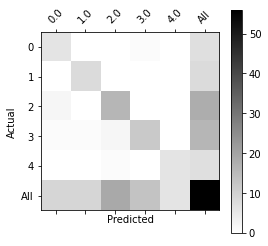

In [38]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

# 2.Emojifier-V2: Using LSTMs in Keras

The previous algorithm did not care about ordering of words ,it's just take the average of all vectors(representation of a word) in a sentence.This way it will perform poorly for a sentence like "not happy".


#Packages

In [40]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

#2.1 Model Overview

![](https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/3a623a00267716d1695e0ce57480f9027648ad4e/C5%20-%20Sequence%20Models/Week%202/Emojify/images/emojifier-v2.png)


In [41]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    X_indices = np.zeros([m,max_len])
    
    for i in range(m):                               # loop over training examples
        
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j =  j+1
    return X_indices

In [42]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [43]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
      
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros([vocab_size,emb_dim])

    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    # keras embedding layer
    embedding_layer = Embedding(vocab_size, emb_dim ,trainable = False)
    # Building the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) 
    
    # Setting the weights of the embedding layer to the embedding matrix.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

#2.2 Building the Emojifier-V2



In [44]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    sentence_indices = Input(shape=input_shape,dtype='int32')
    # Creating the embedding layer pretrained with GloVe Vectors 
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    # Propagate sentence_indices through the embedding layer
    embeddings = embedding_layer(sentence_indices)   
    X = LSTM(units=128,return_sequences = True)(embeddings)
    X = Dropout(0.5)(X)
    X = LSTM(units=128,return_sequences = False)(X)
    X = Dropout(0.5)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)
    return model

In [46]:
maxLen=10
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 50)            20000050  
                                                                 
 lstm (LSTM)                 (None, 10, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645   

In [47]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#2.3 Training the Model

In [48]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [49]:
model.fit(X_train_indices, Y_train_oh, epochs = 100, batch_size = 32, shuffle=True)


Epoch 1/100
5/5 [==============================] - 8s 12ms/step - loss: 1.5830 - accuracy: 0.2652
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 1.5073 - accuracy: 0.3409
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 1.4764 - accuracy: 0.3182
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 1.3675 - accuracy: 0.4015
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 1.3045 - accuracy: 0.5076
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 1.2007 - accuracy: 0.5379
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 1.0417 - accuracy: 0.6136
Epoch 8/100
5/5 [==============================] - 0s 12ms/step - loss: 0.9306 - accuracy: 0.6591
Epoch 9/100
5/5 [==============================] - 0s 11ms/step - loss: 0.8347 - accuracy: 0.6515
Epoch 10/100
5/5 [==============================] - 0s 12ms/step - loss: 0.7825 - accuracy: 0.7045
Epoch 11/100
5/5 [=

In [50]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 1s 12ms/step - loss: 0.7174 - accuracy: 0.8036

Test accuracy =  0.8035714030265808


In [51]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: he got a very nice raise	❤️
Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:😞 prediction: go away	⚾
Expected emoji:❤️ prediction: family is all I have	🍴


In [53]:
x_test = np.array(["What are you eating?"])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

What are you eating? 😞
